In [300]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf

In [301]:
mydata = pd.read_csv('20051201_20051210.csv',index_col='Date')

In [302]:
mydata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-12-01,10806.030273,10934.900391,10806.030273,10912.570313,10912.570313,256980000
2005-12-02,10912.009766,10921.370117,10861.660156,10877.509766,10877.509766,214900000
2005-12-05,10876.950195,10876.950195,10810.669922,10835.009766,10835.009766,237340000
2005-12-06,10835.410156,10936.200195,10835.410156,10856.860352,10856.860352,264630000
2005-12-07,10856.860352,10868.059570,10764.009766,10810.910156,10810.910156,243490000
2005-12-08,10808.429688,10847.250000,10729.669922,10755.120117,10755.120117,253290000
2005-12-09,10751.759766,10805.950195,10729.910156,10778.580078,10778.580078,238930000


In [303]:
def add_original_feature(df, df_new):
    df_new['open']      = df['Open']
    df_new['open_1']    = df['Open'].shift(1)
    df_new['close_1']   = df['Close'].shift(1)
    df_new['high_1']    = df['High'].shift(1)
    df_new['low_1']     = df['Low'].shift(1)
    df_new['volume_1']  = df['Volume'].shift(1)

In [304]:
def add_avg_price(df, df_new):
    df_new['avg_price_5']              = df['Close'].rolling(5).mean().shift(1) #week excluding weekends
    df_new['avg_price_30']             = df['Close'].rolling(21).mean().shift(1) #month excluding weekends
    df_new['avg_price_365']            = df['Close'].rolling(252).mean().shift(1) #year excluding weekends
    df_new['ratio_avg_price_5_30']     = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365']    = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365']   = df_new['avg_price_30'] / df_new['avg_price_365']


In [305]:
def add_avg_volume(df, df_new):
    df_new['avg_volume_5']             = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30']            = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365']           = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30']    = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365']   = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365']  = df_new['avg_volume_30'] / df_new['avg_volume_365']

In [306]:
def add_std_price(df, df_new):
    df_new['std_price_5']               = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30']              = df['Close'].rolling(21).std().shift(1) 
    df_new['std_price_365']             = df['Close'].rolling(252).std().shift(1) 
    
    df_new['ratio_std_price_5_30']      = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365']     = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365']    = df_new['std_price_30'] / df_new['std_price_365']

In [307]:
def add_std_volume(df, df_new):
     df_new['std_volume_5']             = df['Volume'].rolling(5).std().shift(1)
     df_new['std_volume_30']            = df['Volume'].rolling(21).std().shift(1)
     df_new['std_volume_365']           = df['Volume'].rolling(252).std().shift(1)
     
     df_new['ratio_std_volume_5_30']    = df_new['std_volume_5'] / df_new['std_volume_30']
     df_new['ratio_std_volume_5_365']   = df_new['std_volume_5'] / df_new['std_volume_365']
     df_new['ratio_std_volume_30_365']  = df_new['std_volume_30'] / df_new['std_volume_365']

In [308]:
def add_return_feature(df, df_new):
     df_new['return_1']         = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
     df_new['return_5']         = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
     df_new['return_30']        = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
     df_new['return_365']       = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
     
     df_new['moving_avg_5']     = df_new['return_1'].rolling(5).mean().shift(1)
     df_new['moving_avg_30']    = df_new['return_1'].rolling(21).mean().shift(1)
     df_new['moving_avg_365']   = df_new['return_1'].rolling(252).mean().shift(1)

In [309]:
def generate_features(df):
     """
     Generate features for a stock/index based on historical price and performance
     @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
     @return: dataframe, data set with new features
     """
     df_new = pd.DataFrame()
     # 6 original features
     add_original_feature(df, df_new)
     # 31 generated features
     add_avg_price(df, df_new)
     add_avg_volume(df, df_new)
     add_std_price(df, df_new)
     add_std_volume(df, df_new)
     add_return_feature(df, df_new)
     # the target
     df_new['close'] = df['Close']
     df_new = df_new.dropna(axis=0)
     return df_new

In [310]:
data_raw = pd.read_csv('19880101_20161231.csv',index_col='Date')

In [311]:
data = generate_features(data_raw)

In [312]:
data.round(decimals=3).tail(5)

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_365,ratio_avg_price_5_30,...,ratio_std_volume_5_365,ratio_std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,19908.609,19922.680,19918.881,19933.830,19882.189,258290000.0,19912.386,19535.447,17881.613,1.019,...,1.977,2.040,-0.001,0.003,0.047,0.132,0.002,0.002,0.001,19933.811
2016-12-27,19943.461,19908.609,19933.811,19934.150,19899.061,158260000.0,19930.466,19575.953,17891.064,1.018,...,0.819,1.981,0.001,0.005,0.045,0.136,0.001,0.002,0.001,19945.039
2016-12-28,19964.311,19943.461,19945.039,19980.240,19939.801,158540000.0,19942.862,19613.710,17900.654,1.017,...,0.884,1.878,0.001,0.003,0.041,0.138,0.001,0.002,0.001,19833.680
2016-12-29,19835.461,19964.311,19833.680,19981.109,19827.311,188350000.0,19914.674,19648.748,17909.038,1.014,...,0.739,1.798,-0.006,-0.007,0.039,0.119,0.001,0.002,0.001,19819.779
2016-12-30,19833.170,19835.461,19819.779,19878.439,19788.939,172040000.0,19890.238,19681.994,17917.831,1.011,...,0.612,1.715,-0.001,-0.006,0.037,0.126,-0.001,0.002,0.000,19762.600


In [313]:
date_split = '2016'
train_data = data.loc[data.index < date_split]
test_data = data.loc[data.index > date_split]
X_train = train_data.drop(['close'],axis=1)
Y_train = train_data['close']
X_test = test_data.drop(['close'],axis=1)
Y_test = test_data['close']

In [314]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP

In [315]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(37,)))
model.add(tf.keras.layers.Dense(16,activation='relu'))#tf.keras.layers.LeakyReLU()))
model.add(tf.keras.layers.Dense(16,activation='relu'))#tf.keras.layers.LeakyReLU()))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                608       
                                                                 
 dense_39 (Dense)            (None, 16)                272       
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [316]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,start_from_epoch=100,restore_best_weights=True,verbose=1)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.5,patience=10,verbose=1)
callbacks = [earlyStopping,save_model,reduce_lr]


### Compile Model

In [317]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])

In [318]:
hist = model.fit(X_train_scaled,Y_train,validation_split=0.2,epochs=1000,callbacks=callbacks ,verbose=1)

Epoch 1/1000
171/171 [==============================] - 1s 963us/step - loss: 10166315.0000 - mae: 2082.9111 - root_mean_squared_error: 3188.4658 - val_loss: 19986742.0000 - val_mae: 3502.7800 - val_root_mean_squared_error: 4470.6533 - lr: 0.1000
Epoch 2/1000
171/171 [==============================] - 0s 650us/step - loss: 455550.6250 - mae: 501.8430 - root_mean_squared_error: 674.9449 - val_loss: 4328198.5000 - val_mae: 1696.6328 - val_root_mean_squared_error: 2080.4324 - lr: 0.1000
Epoch 3/1000
171/171 [==============================] - 0s 649us/step - loss: 141433.5000 - mae: 281.8578 - root_mean_squared_error: 376.0764 - val_loss: 2135860.7500 - val_mae: 1172.3984 - val_root_mean_squared_error: 1461.4584 - lr: 0.1000
Epoch 4/1000
171/171 [==============================] - 0s 656us/step - loss: 70792.6328 - mae: 202.9957 - root_mean_squared_error: 266.0688 - val_loss: 1407759.6250 - val_mae: 938.7726 - val_root_mean_squared_error: 1186.4905 - lr: 0.1000
Epoch 5/1000
171/171 [=======

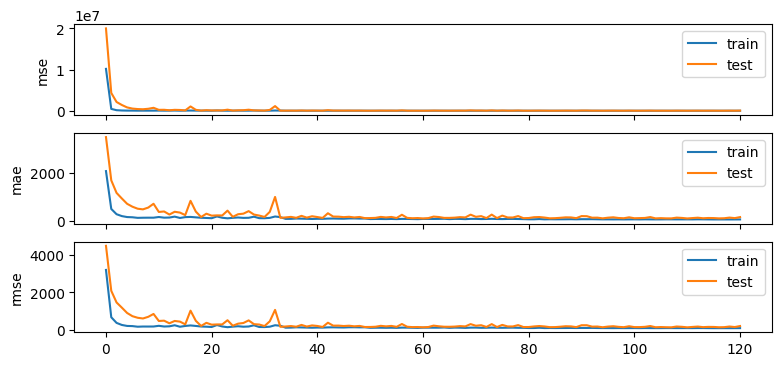

In [319]:
fig, axs = plt.subplots(3,sharex=True,figsize=(9,4))
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_ylabel('mse')
axs[0].legend(['train', 'test'])


axs[1].plot(hist.history['mae'])
axs[1].plot(hist.history['val_mae'])
axs[1].set_ylabel('mae')
axs[1].legend(['train', 'test'])

axs[2].plot(hist.history['root_mean_squared_error'])
axs[2].plot(hist.history['val_root_mean_squared_error'])
axs[2].set_ylabel('rmse')
axs[2].legend(['train', 'test'])
plt.show()

In [320]:
model.evaluate(X_test_scaled,Y_test)

8/8 [==============================] - 0s 571us/step - loss: 26214.0586 - mae: 125.5743 - root_mean_squared_error: 161.9076


[26214.05859375, 125.57426452636719, 161.90756225585938]

In [321]:
predictions = model.predict(X_test_scaled)[:,0]

8/8 [==============================] - 0s 571us/step


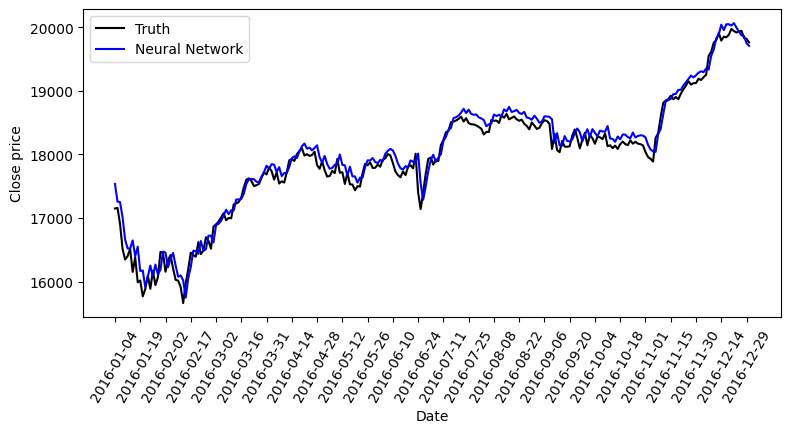

In [322]:
plt.figure(figsize=(9,4))
plt.plot(X_test.index, Y_test, 'k')
plt.plot(X_test.index, predictions, 'b')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural Network'])
plt.show()